In [1]:
# Import
from classes.Base import *
import dolfinx
from dolfinx import mesh, fem, io, nls
from dolfinx.fem import VectorFunctionSpace
from mpi4py import MPI
import numpy as np
import ufl
import matplotlib.pyplot as plt

import jsonpickle as jp
import shutil
import re
import inspect
from tqdm import tqdm

And = Infix(ufl.And)


def check_symmetry(
    func: fem.Function,
    data,
    add_point=0,
):
    from matplotlib.ticker import FormatStrFormatter

    def find_middle(add_point):
        middle_x = (data.light.left + data.light.right) / 2
        middle_point = int((data.mesh.left + middle_x) /
                           (data.mesh.right - data.mesh.left) * base.len)
        middle_point += add_point
        return middle_point

    def plot(func: ArrayFunc):
        fig, ax = plt.subplots(facecolor='White')
        fig.set_size_inches(20, 10)
        ax.grid(True, which='Both')
        ax.set_xlim((min(func.cord[0]), max(func.cord[0])))
        ax.set_ylim((min(func.cord[1]), max(func.cord[1])))
        ax.yaxis.set_major_formatter(FormatStrFormatter(('%.3f')))
        plt.plot([middle, middle], (min(func.cord[1]), max(func.cord[1])),
                 c='red')

        ax.plot(func.cord[0], func.cord[1], label=func.name, color='black')
        ax.fill_between(
            func.cord[0],
            func.cord[1] * 0,
            func.cord[1],
            where=func.cord[1] > func.cord[1] * 0,
            alpha=0.5,
            facecolor='green',
            label=func.name,
        )
        ax.fill_between(
            func.cord[0],
            func.cord[1] * 0,
            func.cord[1],
            where=func.cord[1] < func.cord[1] * 0,
            alpha=0.5,
            facecolor='red',
            label=func.name,
        )

    print('Rule: Right - left')
    base = ArrayFunc(func, 'base')
    dif = ArrayFunc(func, 'dif')
    middle = find_middle(add_point)

    dif.mirror(middle)
    dif.translate(-middle)
    dif.cord[1] = (dif.cord[1] - base.cord[1]) / base.cord[1]
    dif.cord[1, dif.cord[0] >= middle] = 0
    plot(dif)
    plot(base)


def clear_savedir(path_save):
    """Clear directory in VTK folder"""

    try:
        shutil.rmtree(path_save)
    except:
        pass


def view_file1D(
    name,
    dir='/home/VTK/System1D_files/',
    view_dir='/home/VTK/System1D_files/0',
):
    shutil.copytree(dir + name, view_dir, dirs_exist_ok=True)


def repr_str(func, rules: list = {}) -> str:
    # TODO: to module
    # FIXME: (( to (\n(
    rep = str(func)
    rep = re.sub(r'\{ A \| A_\{i_(\d|\{\d+\})\} \=', '', rep)
    rep = re.sub(r'\[i_(\d|{\d+})]', '', rep)
    rep = re.sub(r'dx.+\)', 'dx', rep)
    rep = re.sub(r'ds.+\)', 'ds', rep)
    for key, raw in rules.items():
        rep = rep.replace(str(raw), key)

    base = {
        'v_0[0]': 'v',
        'v_0[1]': 'u',
        '-1 * ': '-',
        '+ -': '-',
        'f[0]': 'N',
        'f[1]': 'P',
        '{': '{\n',
        '} *': '\n} *',
    }
    for key, raw in base.items():
        rep = rep.replace(key, raw)

    beauty = {
        '(grad(P))': 'grad(P)',
        '(grad(N))': 'grad(N)',
        '(grad(u))': 'grad(u)',
        '(grad(v))': 'grad(v)',
        '})': ')',
        '+ (': '\n   +(',
    }
    for key, raw in beauty.items():
        rep = rep.replace(key, raw)
    return rep


In [2]:
from classes import express

In [3]:
# Set up and redefine parametrs
from task_configurations import parametrs

DATA = parametrs.Data('test', 'test desc')
_r = DATA.rates
_r.a, _r.b, _r.e, _r.general = 1, 0.1, 0.5, 0.01

DATA.time.line = np.arange(0, 1, 0.001)
DATA.time.check = DATA.time.line[::100]

_l = DATA.light_confs
_l.left, _l.right, _l.type = 0.4, 0.6, 'stepwise'
DATA.print_info__()

  save_confs  solution_name: test
  save_confs  description: test desc
  save_confs  file_name: solve
  save_confs  dir: /home/Solves/
  solver_confs  solve_options: {'convergence': 'incremental', 'tolerance': 1e-06}
  solver_confs  petsc_options: {'ksp_type': 'preonly', 'pc_type': 'lu', 'pc_factor_mat_solver_type': 'mumps'}
  solver_confs  form_compiler_options: {}
  solver_confs  jit_options: {}
  mesh_confs  left: 0
  mesh_confs  right: 1
  mesh_confs  intervals: 1000
  mesh_confs  degree: 1
  mesh_confs  family: CG
  bcs: {'type': 'close'}
  time  line: [0.0, 0.001 .. 0.998, 0.999]; len = 1000
  time  check: [0.0, 0.1 .. 0.8, 0.9]; len = 10
  rates  a: 1
  rates  b: 0.1
  rates  e: 0.5
  rates  general: 0.01
  rates  P_step: 0.13
  rates  gamma: 4
  light_confs  left: 0.4
  light_confs  right: 0.6
  light_confs  type: stepwise
  light_confs  smoothing: 100
  initial  n: 0.2
  initial  p: 0.001


In [4]:
# Set up space
from ufl import dx
# TODO: Change to another dimension and geometry
domain = mesh.create_interval(
    nx=DATA.mesh_confs.intervals,
    comm=MPI.COMM_WORLD,
    points=[DATA.mesh_confs.left, DATA.mesh_confs.right],
)
mesh_interval = (DATA.mesh_confs.right -
                 DATA.mesh_confs.left) / DATA.mesh_confs.intervals

# TODO: Change to another study and mesh accurancy
variables = 'n,p'
elements = {
    'n': ufl.FiniteElement(family='CG', cell=domain.ufl_cell(), degree=1),
    'p': ufl.FiniteElement(family='CG', cell=domain.ufl_cell(), degree=1),
}

space_info, func_info = express.make_variables(
    domain=domain,
    variables=variables,
    variable_elements=elements,
    n_variable_versions=2,
    )

space = space_info['space']

# TODO: Change to another time disctetisation
func, func0 = func_info[0]['function'], func_info[1]['function']

# TODO: Change to another study 
subspace_n, subspace_p = space_info['subspaces']
subfunc_n, subfunc_p = func_info[0]['subfunctions']
n, p = func_info[0]['variables']
n0, p0 = func_info[1]['variables']

x, y, z = space_info['coordinates']
ds = express.create_facets(domain)

TIME = Constant(subspace_n, 0)
dt = DATA.time.line[1] - DATA.time.line[0]

In [6]:
# Set up equation
from classes import distributions
from task_configurations.BCs import BCs1D

## Light
# TODO: Change to another dimension
light = distributions.Simple1D(
    x=x,
    x0=DATA.light_confs.left,
    smoothing=DATA.light_confs.smoothing,
).create(style=DATA.light_confs.type)
light *= distributions.Simple1D(
    x=x,
    x0=DATA.light_confs.right,
    smoothing=-DATA.light_confs.smoothing,
).create(style=DATA.light_confs.type)

## Constants
_r = DATA.rates
gen_rate = _r.general
P_step = _r.P_step
a_nm = gen_rate * _r.a
b_pm = gen_rate * _r.b * exp(-p / P_step)
e_np = gen_rate * _r.e * exp(-p / P_step)

_g = _r.gamma
m = 1 - p - n
_under_ln = m / (1-n)
_power = (_g-1) / _g
reaction = _g * m * (-ln(_under_ln))**_power

## BCs
BCS = []

## Surface fluxes
surflux_n,surflux_p = BCs1D.create(
    style='like_inside',
    a_nm=a_nm,
    b_pm=b_pm,
    e_np=e_np,
    f=n,
    variables={'n': n, 'p': p},
    n_ext=0.2,
    p_ext=0.01,
    mesh_interval=0.001,
),BCs1D.create(
    style='like_inside',
    a_nm=a_nm,
    b_pm=b_pm,
    e_np=e_np,
    f=p,
    variables={'n': n, 'p': p},
    n_ext=0.2,
    p_ext=0.01,
    mesh_interval=0.001,
)


## Inside fluxes
flux_n = 0
flux_n += -a_nm * grad(n)
flux_n += +a_nm * p * grad(n)
flux_n += -e_np * p * grad(n)
flux_n += -a_nm * n * grad(p)
flux_n += +e_np * n * grad(p)

flux_P = 0
flux_P += -b_pm * grad(p)
flux_P += +b_pm * n * grad(p)
flux_P += -e_np * n * grad(p)
flux_P += -b_pm * p * grad(n)
flux_P += +e_np * p * grad(n)

## Equation
u, v = TestFunctions(space)

equation_n = (1/dt) * (n-n0) * u * dx
equation_n += -(flux_n|inner|grad(u)) * dx
equation_n += u * surflux_n * ds

equation_p = (1/dt) * (p-p0) * v * dx
equation_p += -(flux_P|dot|grad(v)) * dx
equation_p += -light * reaction * v * dx
equation_p += v * surflux_p * ds
equation = equation_n+equation_p

In [30]:
# Set up problem
def make_problem():
    # FIXME: reset bcs
    subfunc_n.interpolate(Function(subspace_n, DATA.initial.n))
    subfunc_p.interpolate(Function(subspace_p, DATA.initial.p))
    func.x.scatter_forward()
    func0.interpolate(func)

    TIME.value = 0
    return NonlinearProblem(
        F=equation,
        bcs=BCS,
        u=func,
        **DATA.solver_confs.get_confs__(),
    )

problem = make_problem()


In [31]:
def change_func():
    func0.interpolate(func)


def solve(problem: NonlinearProblem, time_line, time_check=[0]):
    time_steps = tqdm(desc=f'Solving PDE. Time:{TIME.value:.3f}',
                      iterable=time_line)
    
    for step in time_steps:
        time_steps.set_description(f'Solving PDE. Time:{step:.2f}')
        problem.solve()
        change_func()


solve(problem=problem, time_line=DATA.time.line[:500])

Solving PDE. Time:0.50: 100%|██████████| 500/500 [00:09<00:00, 52.44it/s]


<AxesSubplot:>

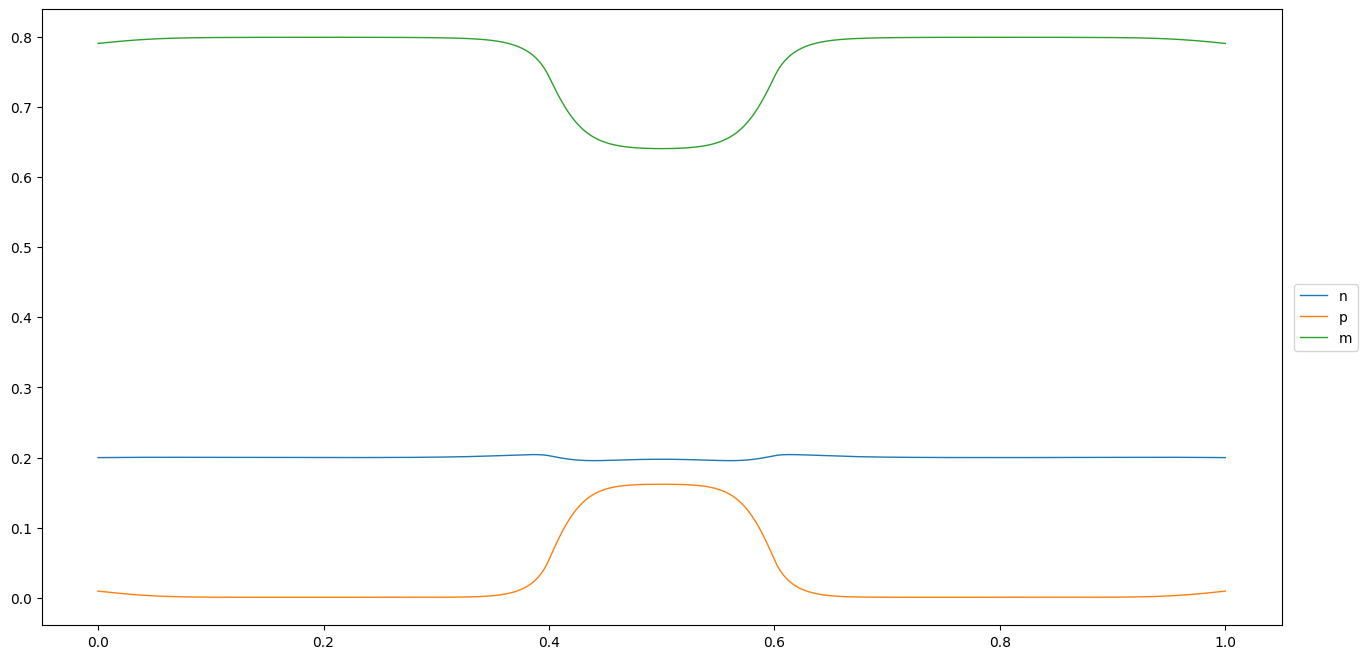

In [32]:
func_plot1D([
    Function(space=subspace_n, form=subfunc_n,name='n'),
    Function(space=subspace_p, form=subfunc_p,name='p'),
    Function(space=subspace_n, form=1-subfunc_p-subfunc_n,name='m'),
])


In [8]:
# def create_equation():

#     def inside_flux(
#         a_NM=CONST['A_NM'],
#         b_PM=CONST['B_PM'],
#         e_NP=CONST['E_NP'],
#     ):
#         flux_N = 0
#         flux_N += -a_NM * grad(n)
#         flux_N += +a_NM * p * grad(n)
#         flux_N += -e_NP * p * grad(n)
#         flux_N += -a_NM * n * grad(p)
#         flux_N += +e_NP * n * grad(p)

#         flux_P = 0
#         flux_P += -b_PM * grad(p)
#         flux_P += +b_PM * n * grad(p)
#         flux_P += -e_NP * n * grad(p)
#         flux_P += -b_PM * p * grad(n)
#         flux_P += +e_NP * p * grad(n)
#         return flux_N, flux_P

#     dt = DATA.time.line[1]-DATA.time.line[0]
#     ds = create_facets()

#     u, v = TestFunctions(space)
#     # n, p = func_indicator[N], func_indicator[P]
#     # n0, p0 = func_indicator0[N], func_indicator0[P]
#     qN, qP = inside_flux()

#     equationN = (1/dt) * (n-n0) * u * dx
#     equationN += -(qN|inner|grad(u)) * dx
#     equationN += u * SURFACE['N'] * ds

#     equationP = (1/dt) * (p-p0) * v * dx
#     equationP += -(qP|dot|grad(v)) * dx
#     equationP += -light * CONST['REACTION'] * v * dx
#     equationP += v * SURFACE['P'] * ds

#     return {'N': equationN, 'P': equationP}

# EQUATION = create_equation()
# # FIXME: clear reset KSP solver
# PROBLEM = []


# Initial
# def set_initial(
#     data: Param_initial = DATA.initial,
#     confs=DATA.solve_confs,
# ):
#     # TODO: reset bcs
#     SUB_FUNC['N'].interpolate(Function(SUBSPACE['N'], data.N0))
#     SUB_FUNC['P'].interpolate(Function(SUBSPACE['P'], data.P0))

#     FUNC.x.scatter_forward()
#     FUNC0.interpolate(FUNC)

#     TIME.value = 0
#     global PROBLEM
#     PROBLEM = NonlinearProblem(
#         F=sum(EQUATION.values()),
#         bcs=BCS,
#         u=FUNC,
#         solve_options=confs.solve_opts,
#         petsc_options=confs.petsc_opts,
#         form_compiler_params=confs.form_opts,
#         jit_params=confs.jit_opts,
#     )


# set_initial()


In [ ]:
# Functions
def dump(save=False, DATA=DATA):
    consts = CONST.copy()
    DATA.dump.consts = {key: repr_str(value) for key, value in consts.items()}
    consts.update({'LIGHT': light})
    DATA.dump.equations = {
        key: repr_str(value, consts)
        for key, value in EQUATION.items()
    }

    if not save:
        print(DATA.dump.EQUATION_N)
        print('*' * 80)
        print(DATA.dump.EQUATION_P)
    else:
        with open(
                DATA.save.dir_save + DATA.save.save_name + DATA.save.file_name +
                '_anotaton.txt',
                'w',
        ) as annotation:
            annotation.write(jp.encode(DATA, numeric_keys=True, indent=4))
    pass


def solve(n_steps=DATA.time.n_steps, reset=True, save=False):

    def _set_next():
        # TODO: interpolate bcs
        FUNC0.interpolate(FUNC)
        TIME.value += DATA.time.dt

    def _solve_default(steps):
        for step in steps:
            _set_next()
            steps.set_description(f'Solving PDE. Time:{TIME.value:.2f}')
            PROBLEM.solve()

    def _solve_with_save(steps, data_save: Param_save = DATA.save):

        def _save_functions(file, time):
            file.write_function(SUB_FUNC['N'], time)
            file.write_function(SUB_FUNC['P'], time)
            # flux_N = Function(SUBSPACE[N], SURFACE[N])
            # flux_N.name = 'flux_N'
            # file.write_function(flux_N, time)

            # flux_P = Function(SUBSPACE.P, SURFACE.P)
            # flux_P.name = 'flux_P'
            # file.write_function(flux_P, time)

        clear_savedir(data_save.dir_save + data_save.save_name)
        save_path = data_save.dir_save + data_save.save_name + data_save.file_name
        check_every = int(DATA.time.n_steps / DATA.time.n_checks)

        SUB_FUNC['N'].name = 'neutral'
        SUB_FUNC['P'].name = 'polimer'
        light = Function(SUBSPACE['N'], light)
        light.name = 'Light'
        with io.XDMFFile(domain.comm, save_path + '.xdmf', 'w') as file:
            file.write_mesh(domain)
            for step in steps:
                if step % check_every == 0:
                    steps.set_description(f'Solving PDE. Time:{TIME.value:.2f}')
                    _save_functions(file, TIME.value)
                _set_next()
            _save_functions(file, TIME.value)
        dump(True)

    if reset: set_initial()
    steps_line = tqdm(
        desc=f'Solving PDE. Time:{TIME.value:.3f}',
        iterable=np.arange(0, n_steps, dtype=int),
    )
    if save: _solve_with_save(steps_line, data_save=DATA.save)
    else: _solve_default(steps_line)


def draw(show_fluxes=False, flux_scale=100, show_points=False):
    col_light = Function(SUBSPACE['N'], light, 'Light')
    col_funcs = {}
    col_fluxes = {}

    for key in SUB_FUNC.keys():
        col_funcs.update({key: Function(SUBSPACE[key], SUB_FUNC[key], key)})
        col_fluxes.update({key:Function(SUBSPACE[key], flux_scale * SURFACE[key], 'flux_' + key)}) #yapf: disable
    col_M = Function(SUBSPACE['N'], 1 - col_funcs['N'] - col_funcs['P'], 'M')

    collection = [col_M, col_light, *col_funcs.values()]
    if show_fluxes: collection.append(*col_fluxes.values())
    func_plot1D(funcs=collection, show_points=show_points)


In [ ]:
solve(
    save=False,
        # n_steps=2000,
    reset=True,
)
draw()

In [ ]:
check_symmetry(data=DATA,
               add_point=0,
               func=Function(SUBSPACE['N'], SUB_FUNC['N'], 'neutral'))
